# Classification of Cancer associated Mutations from Literature using Machine Learning

Use the "Run" button to execute the code.

In [6]:
pip install jovian --upgrade --quiet

Note: you may need to restart the kernel to use updated packages.


distutils: C:\Users\anubr\anaconda3\Include\UNKNOWN
sysconfig: C:\Users\anubr\anaconda3\Include
user = False
home = None
root = None
prefix = None
distutils: C:\Users\anubr\anaconda3\Include\UNKNOWN
sysconfig: C:\Users\anubr\anaconda3\Include
user = False
home = None
root = None
prefix = None


In [7]:
# Execute this to save new versions of the notebook
jovian.commit(project="jovian-ml-project-030122",filename="jovian-ml-project-030122")

<IPython.core.display.Javascript object>

[jovian] Updating notebook "anubratadas/classification-of-cancer-mutations" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/anubratadas/classification-of-cancer-mutations


'https://jovian.ai/anubratadas/classification-of-cancer-mutations'

### <font color='green'>Import the essential libraries</font>

In [8]:
import jovian
import pandas as pd
import numpy as np
import requests
import xml.etree.ElementTree as ET
import time
import re
from tqdm import tqdm
%matplotlib inline

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.simplefilter(action='ignore')

In [10]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [11]:
tqdm.pandas(desc="progress bar")

 ### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height: 0.8;word-spacing: 10px"> A cancerous tissue can have thousands of genetic mutations (Variations), which are discovered using genome sequencing. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature. For this competition MSKCC is making available an expert-annotated knowledge base where world-class researchers and oncologists have manually annotated thousands of mutations. MSKCC intends the Data scientist to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.</font>

<a id='top'>**Beginning of Notebook**</a>

[model train text data](#train_data)

### <font color='green'>Exploratory Data Analysis</font>

###  references
  - https://github.com/ghostintheshellarise/2021HackForRare
  - https://widdowquinn.github.io/2018-03-06-ibioic/02-sequence_databases/09-KEGG_programming.html
  - https://bioservices.readthedocs.io/en/master/kegg_tutorial.html
  - https://bioservices.readthedocs.io/en/master/index.html

#### train data

In [12]:
train_text_df = pd.read_csv('training_text.zip', sep="\|\|", encoding="utf-8",engine="python", skiprows=1, names=["ID", "Text"],compression='zip')

In [13]:
train_variant_df = pd.read_csv('training_variants.zip',compression='zip')

In [14]:
train_text_df.shape, train_variant_df.shape

((3321, 2), (3321, 4))

In [15]:
train_text_df.columns, train_variant_df.columns

(Index(['ID', 'Text'], dtype='object'),
 Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object'))

In [16]:
# merging the text and variation data
train_df = pd.merge(train_variant_df,train_text_df,on='ID')

In [17]:
train_text_df.head(n=4)

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...


In [18]:
train_variant_df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [19]:
train_df.shape

(3321, 5)

In [20]:
# taking a sample of the dataset
#train_df = train_df.sample(frac=0.6,random_state=222)

We have taken a sample of the training data

In [22]:
train_df.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


![](https://imgur.com/kO8UAXb.png)

image courtesy http://igbiologyy.blogspot.com/2014/03/chromosomes-dna-genes-and-alleles.html

### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height: 0.8;word-spacing: 10px"><i>Gene</i> is a stretch of DNA encoding a specific functional molecule, a protein. Variation is <i>Mutation</i>,  which occurs in the gene and changes the function of the protein. Proteins are made up of 20 amino acids and these are designated by the following alphabets; A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y and V. In the variation column, the first alphabet is the orginal amino acid, the number is the physical position in the gene where the change has occured and the last alphabet is the changed amino acid. The Text dataset contains the information for the Gene, the Variation and the Class column in the variants dataset. The 2 datasets are linked by the common ID column</font>

### The distribution of mutations per gene in the dataset

In [25]:
mutation_pattern=train_df.groupby(['Gene'])[['Variation']].aggregate("count").sort_values("Variation",ascending=False)

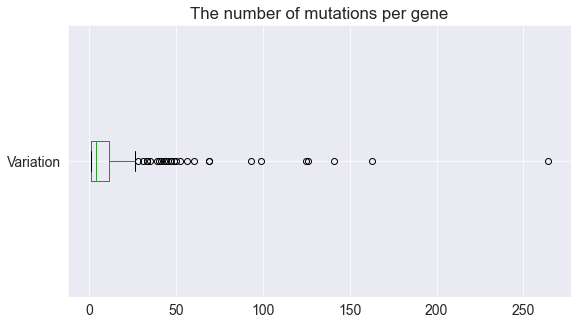

In [26]:
mutation_pattern[['Variation']].boxplot(vert=False);
plt.title("The number of mutations per gene");

In [27]:
mutation_pattern.shape

(264, 1)

In [28]:
mutation_pattern['Variation'].median()

4.0

In [29]:
mutation_pattern['Variation'].mode()

0    1
dtype: int64

In [30]:
from scipy.special import factorial

def poisson(k, lamb):
    """poisson pdf, parameter lamb is the fit parameter"""
    return (lamb**k/factorial(k)) * np.exp(-lamb)

In [31]:
lamb=mutation_pattern['Variation'].mean()

In [32]:
k=mutation_pattern['Variation'].to_numpy()

In [33]:
k=np.sort(k)

In [34]:
y=poisson(k,lamb)

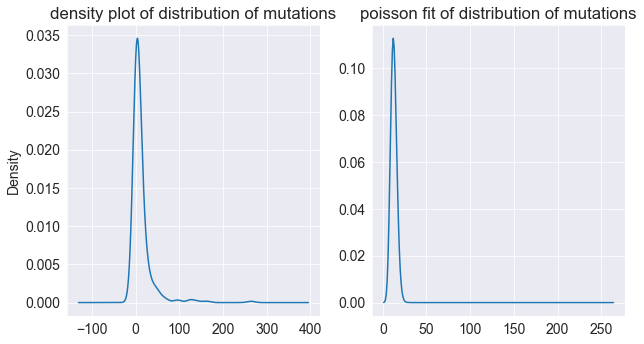

In [35]:
plt.subplot(1,2,1)
mutation_pattern['Variation'].plot.density();
plt.title("density plot of distribution of mutations")
plt.subplot(1,2,2)
plt.plot(k,y);
plt.title("poisson fit of distribution of mutations")
plt.tight_layout()

In [36]:
mutated_genes=train_df['Gene'].to_list()

### <font style="font-size:18px;font-family:arial;color:blue;text-indent:100px;line-height: 0.8;word-spacing: 10px"> Mutation acquisition is a rare event. The Poisson distribution is used to describe the distribution of rare events in a large population. For example, at any particular time, there is a certain probability that a particular cell within a large population of cells will acquire a mutation.                                                                                   -Frank H. Stephenson, in Calculations for Molecular Biology and Biotechnology (Second Edition), 2010. The distribution of mutations per gene in this dataset follows the usual pattern of Poisson distribution seen in general for mutations. 3321 mutations, or variations, are distributed in 195 genes. 14 genes have more than 20 mutations, which are often classified in different classes. It would be worthwhile to investigate, why certain mutations are classified in certain specific classes </font>

### <font color='green'>The distribution of classes in the dataset </font>

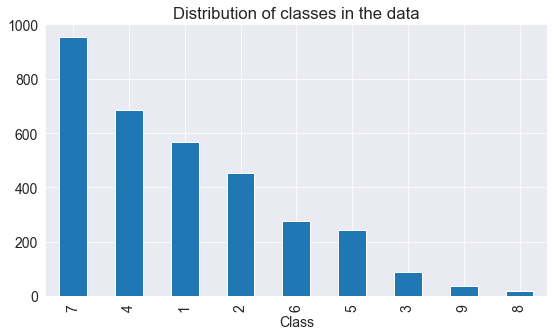

In [37]:
train_df.value_counts('Class').plot(kind='bar');
plt.title("Distribution of classes in the data");

### <font color='blue'>The mutations are distributed into 9 classes, from class 1 to class 9.The distribution of the classes is imbalanced </font>

In [38]:
train_df[train_df['Class']==8]['Gene'].nunique()

12

In [43]:
train_df[train_df['Class']==7]['Gene'].nunique()

108

### <font color="blue"> The largest class, class 7, has 108 genes which is almost half of all the mutated genes, while class 8, the smallest class has 12 genes. Let us see if all genes in class 7 have the same number of mutations per gene </font>

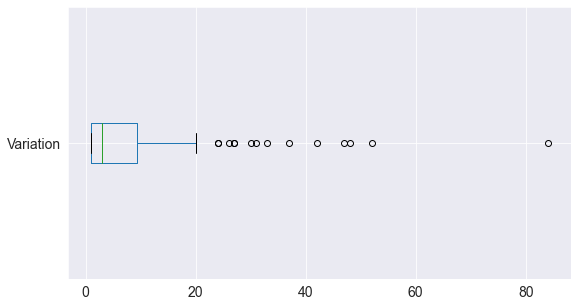

In [63]:
train_df[train_df['Class']==7].groupby('Gene')[['Variation']].count().boxplot(vert=False);

In [69]:
train_df[train_df['Class']==7]['Variation'].nunique()

889

In [36]:
class_7_genes=train_df[train_df['Class']==7]['Gene'].drop_duplicates().tolist()

In [46]:
class_4_genes=train_df[train_df['Class']==4]['Gene'].drop_duplicates().tolist()

In [47]:
class_1_genes=train_df[train_df['Class']==1]['Gene'].drop_duplicates().tolist()

### <font color='blue'> The pattern of mutations per gene, is same as the overall dataset and hence,no obvious numerical pattern is present in classifying the mutations in class 7. Let us furthere explore a few other possibilites for the classification </font>

### <font color='green'>The Signalling Pathways in Cancer</font>

![](https://i.imgur.com/yk4ib0M.jpg)

### <font color='blue'> Proteins encoded by respective genes, function together in elaborate sequences called <i>Pathways<i> ,to create the final outcome. For cancer, the sequence mostly starts with a signal outside the cell. Proteins called receptors recieve the signal, and pass it on to a sequence of other proteins downstream,finally to a protein called Transcription Activator, which then switches other genes on and off to make the cancer cell survive and proliferate. Here, we will attempt to see, if the classification is based on these pathways, and we will test class 7 as an example </font>

### Pathwy analysis with Bioservices library and KEGG Database

In [73]:
#!pip install bioservices

Bioservices is a Python package that provides access to many Bioinformatices Web Services (e.g., UniProt) and a framework to easily implement Web Services wrappers (based on WSDL/SOAP or REST protocols)

In [29]:
from Bio.KEGG import REST
from bioservices.kegg import KEGG
#from collections import deque
import networkx as nx
from IPython.display import Image
import time
import re

#### <font color ='blue'>KEGG PATHWAY is a collection of manually drawn pathway maps representing our knowledge of the molecular interaction, reaction and relation networks for:
1. Metabolism
    Global/overview   Carbohydrate   Energy   Lipid   Nucleotide   Amino acid   Other amino   Glycan
    Cofactor/vitamin   Terpenoid/PK   Other secondary metabolite   Xenobiotics   Chemical structure
2. Genetic Information Processing
3. Environmental Information Processing
4. Cellular Processes
5. Organismal Systems
6. Human Diseases
7. Drug Development
</font>    

In [30]:
kegg_obj=KEGG()

#### the get method gets the data pertainng to ALK gene *'ALK') for humans ('hsa') from the KEGG database

In [77]:
print(kegg_obj.get("hsa:ALK"))

ENTRY       238               CDS       T01001
SYMBOL      ALK, ALK1, CD246, NBLST3
NAME        (RefSeq) ALK receptor tyrosine kinase
ORTHOLOGY   K05119  anaplastic lymphoma kinase [EC:2.7.10.1]
ORGANISM    hsa  Homo sapiens (human)
PATHWAY     hsa05200  Pathways in cancer
            hsa05223  Non-small cell lung cancer
            hsa05235  PD-L1 expression and PD-1 checkpoint pathway in cancer
NETWORK     nt06210  ERK signaling
            nt06214  PI3K signaling
            nt06219  JAK-STAT signaling
            nt06220  Calcium signaling
            nt06266  Non-small cell lung cancer
  ELEMENT   N00007  EML4-ALK fusion kinase to RAS-ERK signaling pathway
            N00025  EML4-ALK fusion kinase to PLCG-ERK signaling pathway
            N00047  EML4-ALK fusion kinase to PI3K signaling pathway
            N00105  EML4-ALK fusion kinase to Jak-STAT signaling pathway
            N10003  First-generation tyrosine kinase inhibitor to ALK fusion
            N10004  Second/third-gener

#### get the list of all human genes from the KEGG Database and use re module to extract gene name

In [31]:
human_gene_list=kegg_obj.list('hsa')

In [32]:
human_gene_list=human_gene_list.split('\n')

In [82]:
human_gene_list[0]

'hsa:100616498\tMIR378E, mir-378e; microRNA 378e'

In [83]:
re.sub('[\t;]',',',human_gene_list[0])

'hsa:100616498,MIR378E, mir-378e, microRNA 378e'

In [84]:
re.search('\t\w+','hsa:100616498\tMIR378E, mir-378e; microRNA 378e').group()[1:]

'MIR378E'

In [33]:
def get_kegg_indices(human_gene_list):
    """ this function gets the gene name and KEGG Database IDs"""
    gene_kegg_id_dict={}
    for item in human_gene_list:
        try:
            kegg_id=re.search('^\w+:\w+',item).group()
        except:
            kegg_id='no_entry'
        try:
            gene=re.search('\t\w+',item).group()[1:]
        except:
            gene='no_gene'            
        gene_kegg_id_dict[gene]=kegg_id
    return gene_kegg_id_dict    

In [34]:
def map_mutation_kegg(mutated_genes,human_gene_list):
    """this function maps the mutated genes to KEGG Database IDs"""
    print("mutated genes in class 7 ",len(mutated_genes))
    print("genes in KEGG Database ",len(human_gene_list))
    mut_gene_kegg=[]
    kegg_gene_dict=get_kegg_indices(human_gene_list)
    for mut_gene in mutated_genes:
        if mut_gene in kegg_gene_dict:
            gene_tup=(mut_gene,kegg_gene_dict[mut_gene])
            mut_gene_kegg.append(gene_tup)
    return mut_gene_kegg        

#### get the KEGG gene IDs for mutated genes for class 7

In [37]:
class_7_mutated_kegg=map_mutation_kegg(class_7_genes,human_gene_list)

mutated genes in class 7  108
genes in KEGG Database  22232


In [38]:
def df_gene_pathway(mutated_genes):    
    """this function maps the pathways from KEGG Database to the mutated genes"""
    df_gene_pathway=pd.DataFrame(columns=["gene","pathway"])
    for gene in tqdm(mutated_genes):    
        try:
            pathway_origin=kegg_obj.get_pathway_by_gene(gene,"hsa")
            pathway_list=list(set(pathway_origin.keys()))
            for pathway in pathway_list:
                path_obj=kegg_obj.get(pathway)
                path_name=kegg_obj.parse(path_obj)['NAME'][0]          # get the name of the pathway 
                path_name=re.sub(' -\s\w*\s\w*\s\(\w*\)',"",path_name) # remove the trailing text after hyphen
                df_gene_pathway=df_gene_pathway.append({"pathway":path_name,"gene":gene},ignore_index=True)
        except:
            print("no data for ",gene)
    return df_gene_pathway       

In [39]:
class7_gene_pathway=df_gene_pathway(class_7_genes)

  0%|          | 0/108 [00:00<?, ?it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7015              CDS       T01001) into github.com/bioservices. Thanks T.C.
  1%|          | 1/108 [00:02<04:50,  2.72s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6009              CDS       T01001) into github.com/bioservices. Thanks T.C.
  2%|▏         | 2/108 [00:07<07:21,  4.17s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (896               CDS       T01001) into github.com/bioservices. Thanks T.C.
  3%|▎         | 3/108 [00:14<08:50,  5.06s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. pleas

no data for  RIT1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (898               CDS       T01001) into github.com/bioservices. Thanks T.C.
  5%|▍         | 5/108 [00:20<07:17,  4.24s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1956              CDS       T01001) into github.com/bioservices. Thanks T.C.
  6%|▌         | 6/108 [00:36<14:04,  8.28s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7080              CDS       T01001) into github.com/bioservices. Thanks T.C.
  6%|▋         | 7/108 [00:36<09:29,  5.64s/it]

no data for  NKX2-1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1964              CDS       T01001) into github.com/bioservices. Thanks T.C.
  7%|▋         | 8/108 [00:37<06:35,  3.95s/it]

no data for  EIF1AX


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (23476             CDS       T01001) into github.com/bioservices. Thanks T.C.
  8%|▊         | 9/108 [00:37<04:35,  2.78s/it]

no data for  BRD4


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5058              CDS       T01001) into github.com/bioservices. Thanks T.C.
  9%|▉         | 10/108 [00:44<06:38,  4.07s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7113              CDS       T01001) into github.com/bioservices. Thanks T.C.
 10%|█         | 11/108 [00:45<05:22,  3.32s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6098              CDS       T01001) into github.com/bioservices. Thanks T.C.
 11%|█         | 12/108 [00:46<03:51,  2.41s/it]

no data for  ROS1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2033              CDS       T01001) into github.com/bioservices. Thanks T.C.
 12%|█▏        | 13/108 [00:55<07:09,  4.52s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1019              CDS       T01001) into github.com/bioservices. Thanks T.C.
 13%|█▎        | 14/108 [01:05<09:34,  6.11s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1021              CDS       T01001) into github.com/bioservices. Thanks T.C.
 14%|█▍        | 15/108 [01:13<10:30,  6.78s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
 

no data for  CDK8


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2064              CDS       T01001) into github.com/bioservices. Thanks T.C.
 16%|█▌        | 17/108 [01:21<08:34,  5.65s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2065              CDS       T01001) into github.com/bioservices. Thanks T.C.
 17%|█▋        | 18/108 [01:24<07:06,  4.74s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2066              CDS       T01001) into github.com/bioservices. Thanks T.C.
 18%|█▊        | 19/108 [01:26<06:03,  4.08s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
 

no data for  FOXA1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4193              CDS       T01001) into github.com/bioservices. Thanks T.C.
 29%|██▊       | 31/108 [02:07<04:55,  3.83s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2146              CDS       T01001) into github.com/bioservices. Thanks T.C.
 30%|██▉       | 32/108 [02:08<03:49,  3.02s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4194              CDS       T01001) into github.com/bioservices. Thanks T.C.
 31%|███       | 33/108 [02:09<03:01,  2.42s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
 

no data for  WHSC1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (8493              CDS       T01001) into github.com/bioservices. Thanks T.C.
 49%|████▉     | 53/108 [07:35<02:34,  2.81s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (253260            CDS       T01001) into github.com/bioservices. Thanks T.C.
 50%|█████     | 54/108 [07:36<01:57,  2.17s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3417              CDS       T01001) into github.com/bioservices. Thanks T.C.
 51%|█████     | 55/108 [07:38<02:01,  2.29s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
 

no data for  TET1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6608              CDS       T01001) into github.com/bioservices. Thanks T.C.
 57%|█████▋    | 62/108 [08:32<04:23,  5.73s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (84433             CDS       T01001) into github.com/bioservices. Thanks T.C.
 58%|█████▊    | 63/108 [08:33<03:19,  4.42s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (100271849         CDS       T01001) into github.com/bioservices. Thanks T.C.
 59%|█████▉    | 64/108 [08:34<02:29,  3.41s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
 

 82%|████████▏ | 89/108 [13:41<02:52,  9.05s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2767              CDS       T01001) into github.com/bioservices. Thanks T.C.
 83%|████████▎ | 90/108 [13:48<02:29,  8.31s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3791              CDS       T01001) into github.com/bioservices. Thanks T.C.
 84%|████████▍ | 91/108 [13:51<01:57,  6.94s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2776              CDS       T01001) into github.com/bioservices. Thanks T.C.
 85%|████████▌ | 92/108 [14:59<06:44, 25.30s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing fo

no data for  DDR2


 98%|█████████▊| 106/108 [18:44<00:20, 10.06s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5979              CDS       T01001) into github.com/bioservices. Thanks T.C.
 99%|█████████▉| 107/108 [18:46<00:07,  7.71s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (861               CDS       T01001) into github.com/bioservices. Thanks T.C.
100%|██████████| 108/108 [18:49<00:00, 10.45s/it]


In [40]:
class7_gene_pathway.head()

,gene,pathway
0,TERT,Gastric cancer
1,TERT,Pathways in cancer
2,TERT,Human papillomavirus infection
3,TERT,Human T-cell leukemia virus 1 infection
4,TERT,Hepatocellular carcinoma


In [41]:
class7_gene_pathway.drop_duplicates(inplace=True)

In [42]:
class7_gene_pathway.shape

(2814, 2)

In [43]:
class7_gene_pathway.to_csv('class7_gene_pathway.csv',header=True,index=False)

In [44]:
class7_gene_pathway=pd.read_csv("class7_gene_pathway.csv")

In [45]:
class7_gene_pathway.groupby('pathway').count().sort_values('gene',ascending=False)

,gene
pathway,
Pathways in cancer,65
PI3K-Akt signaling pathway,48
Proteoglycans in cancer,39
Human cytomegalovirus infection,37
Human papillomavirus infection,36
Prostate cancer,35
MAPK signaling pathway,35
MicroRNAs in cancer,35
Ras signaling pathway,34


In [48]:
class_4_mutated_kegg=map_mutation_kegg(class_4_genes,human_gene_list)

mutated genes in class 7  92
genes in KEGG Database  22232


In [49]:
class4_gene_pathway=df_gene_pathway(class_4_genes)

  0%|          | 0/92 [00:00<?, ?it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (867               CDS       T01001) into github.com/bioservices. Thanks T.C.
  1%|          | 1/92 [00:03<05:01,  3.32s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (8036              CDS       T01001) into github.com/bioservices. Thanks T.C.
  2%|▏         | 2/92 [00:04<02:39,  1.77s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7015              CDS       T01001) into github.com/bioservices. Thanks T.C.
  3%|▎         | 3/92 [00:06<03:04,  2.07s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please re

no data for  PTPRT


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (10111             CDS       T01001) into github.com/bioservices. Thanks T.C.
  7%|▋         | 6/92 [00:08<01:37,  1.14s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7046              CDS       T01001) into github.com/bioservices. Thanks T.C.
  8%|▊         | 7/92 [00:17<04:58,  3.51s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7048              CDS       T01001) into github.com/bioservices. Thanks T.C.
  9%|▊         | 8/92 [00:26<07:38,  5.46s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    ide

no data for  EPCAM


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2033              CDS       T01001) into github.com/bioservices. Thanks T.C.
 18%|█▊        | 17/92 [01:04<06:50,  5.47s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7157              CDS       T01001) into github.com/bioservices. Thanks T.C.
 20%|█▉        | 18/92 [01:21<11:05,  8.99s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4087              CDS       T01001) into github.com/bioservices. Thanks T.C.
 21%|██        | 19/92 [01:29<10:24,  8.55s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  RBM10


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (8242              CDS       T01001) into github.com/bioservices. Thanks T.C.
 37%|███▋      | 34/92 [02:34<02:26,  2.52s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2120              CDS       T01001) into github.com/bioservices. Thanks T.C.


no data for  KDM5C


 38%|███▊      | 35/92 [02:34<01:52,  1.98s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7248              CDS       T01001) into github.com/bioservices. Thanks T.C.
 39%|███▉      | 36/92 [02:39<02:35,  2.78s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (10320             CDS       T01001) into github.com/bioservices. Thanks T.C.
 40%|████      | 37/92 [02:39<01:50,  2.01s/it]

no data for  IKZF1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7249              CDS       T01001) into github.com/bioservices. Thanks T.C.
 41%|████▏     | 38/92 [02:45<02:46,  3.08s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (8314              CDS       T01001) into github.com/bioservices. Thanks T.C.
 42%|████▏     | 39/92 [02:45<01:57,  2.21s/it]

no data for  BAP1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4221              CDS       T01001) into github.com/bioservices. Thanks T.C.
 43%|████▎     | 40/92 [02:46<01:36,  1.85s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2175              CDS       T01001) into github.com/bioservices. Thanks T.C.
 45%|████▍     | 41/92 [02:46<01:14,  1.46s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (58508             CDS       T01001) into github.com/bioservices. Thanks T.C.
 46%|████▌     | 42/92 [02:47<01:04,  1.29s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  FAT1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5295              CDS       T01001) into github.com/bioservices. Thanks T.C.
 48%|████▊     | 44/92 [03:22<08:47, 10.99s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4292              CDS       T01001) into github.com/bioservices. Thanks T.C.
 49%|████▉     | 45/92 [03:25<06:37,  8.46s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (8405              CDS       T01001) into github.com/bioservices. Thanks T.C.
 50%|█████     | 46/92 [03:25<04:39,  6.08s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  PMS1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7428              CDS       T01001) into github.com/bioservices. Thanks T.C.
 55%|█████▌    | 51/92 [03:38<01:56,  2.83s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6416              CDS       T01001) into github.com/bioservices. Thanks T.C.
 57%|█████▋    | 52/92 [03:45<02:40,  4.01s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5395              CDS       T01001) into github.com/bioservices. Thanks T.C.
 58%|█████▊    | 53/92 [03:46<01:57,  3.02s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  KNSTRN


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (324               CDS       T01001) into github.com/bioservices. Thanks T.C.
 62%|██████▏   | 57/92 [03:54<01:39,  2.85s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4436              CDS       T01001) into github.com/bioservices. Thanks T.C.
 63%|██████▎   | 58/92 [03:56<01:25,  2.53s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3417              CDS       T01001) into github.com/bioservices. Thanks T.C.
 64%|██████▍   | 59/92 [03:58<01:21,  2.47s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  PPP6C


 70%|██████▉   | 64/92 [04:25<01:26,  3.10s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (100271849         CDS       T01001) into github.com/bioservices. Thanks T.C.
 71%|███████   | 65/92 [04:26<01:06,  2.48s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (472               CDS       T01001) into github.com/bioservices. Thanks T.C.
 72%|███████▏  | 66/92 [04:31<01:25,  3.28s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5604              CDS       T01001) into github.com/bioservices. Thanks T.C.
 73%|███████▎  | 67/92 [05:01<04:41, 11.27s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for no

no data for  TET2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (51755             CDS       T01001) into github.com/bioservices. Thanks T.C.
 76%|███████▌  | 70/92 [05:02<01:30,  4.12s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (567               CDS       T01001) into github.com/bioservices. Thanks T.C.


no data for  CDK12


 77%|███████▋  | 71/92 [05:04<01:15,  3.57s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2625              CDS       T01001) into github.com/bioservices. Thanks T.C.
 78%|███████▊  | 72/92 [05:06<00:58,  2.93s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (9817              CDS       T01001) into github.com/bioservices. Thanks T.C.
 79%|███████▉  | 73/92 [05:08<00:53,  2.82s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5728              CDS       T01001) into github.com/bioservices. Thanks T.C.
 80%|████████  | 74/92 [05:18<01:27,  4.88s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for no

no data for  PRDM1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6790              CDS       T01001) into github.com/bioservices. Thanks T.C.
 83%|████████▎ | 76/92 [05:19<00:43,  2.70s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6794              CDS       T01001) into github.com/bioservices. Thanks T.C.
 84%|████████▎ | 77/92 [05:22<00:42,  2.82s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5781              CDS       T01001) into github.com/bioservices. Thanks T.C.
 85%|████████▍ | 78/92 [05:29<00:53,  3.85s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  FOXL2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5789              CDS       T01001) into github.com/bioservices. Thanks T.C.
 88%|████████▊ | 81/92 [05:31<00:18,  1.67s/it]

no data for  PTPRD


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 89%|████████▉ | 82/92 [05:33<00:18,  1.88s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (673               CDS       T01001) into github.com/bioservices. Thanks T.C.
 90%|█████████ | 83/92 [05:48<00:53,  5.98s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (675               CDS       T01001) into github.com/bioservices. Thanks T.C.
 91%|█████████▏| 84/92 [05:51<00:38,  4.84s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

In [50]:
class4_gene_pathway.drop_duplicates(inplace=True)

In [51]:
class4_gene_pathway.to_csv('class4_gene_pathway.csv',header=True,index=False)

In [52]:
class4_gene_pathway.groupby('pathway').count().sort_values('gene',ascending=False)

,gene
pathway,
Pathways in cancer,37
Human T-cell leukemia virus 1 infection,19
MicroRNAs in cancer,19
Hepatocellular carcinoma,18
Gastric cancer,17
Human papillomavirus infection,17
Cellular senescence,16
PI3K-Akt signaling pathway,16
FoxO signaling pathway,15


In [ ]:
import networkx as nx

In [ ]:
print(plt.rcParams.get('figure.figsize'))

In [ ]:
plt.rcParams["figure.figsize"] = [12.0,10.0]

In [ ]:
G = nx.from_pandas_edgelist(gene_pathway,source="gene",target="pathway")

In [ ]:
nx.draw_networkx(G,alpha=0.6)

### <font color='green'> Let us study the mutations of BRCA1, the most highly mutated gene with respect to the classification</font>

In [ ]:
train_df[train_df['Gene'] == 'BRCA1']['Variation'].nunique()

In [ ]:
train_df[train_df['Gene'] == 'BRCA1']['Class'].nunique()

In [ ]:
train_df[train_df['Gene'] == 'BRCA1'].groupby('Class')['Variation'].count()

### <font color='green'> 101 mutations (Variations) are classified into 5 classes with most mutations in class 5 and least mutations in class 3</font>

In [ ]:
class_5=train_df[(train_df['Gene'] == 'BRCA1') & (train_df['Class']== 5)]
class_5['Text']=class_5['Text'].map(lambda x:x[:80])

In [ ]:
class_5.reset_index(inplace=True,drop=True)

In [ ]:
class_5

In [ ]:
class_5.groupby(['Text','Gene'],sort=False)['Variation'].count().reset_index()

### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height:0.8;word-spacing:10px">What is the relationship of the enlisted mutations (Variation) of a gene and the corresponding 'Text' ? For e.g, for mutations of BCRA1, there are 36 unique mutations assigned to class 5 and the above 10 texts are the basis for it</font>

In [ ]:
train_df.isna().sum()

In [ ]:
train_df[train_df['Text'].map(lambda x:not isinstance(x,str))]

In [ ]:
train_df.dropna(inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y_train=train_df['Class']
X_train=train_df.drop('Class',axis=1)
train_df,validation_df,y_train,y_validation=train_test_split(X_train,y_train,test_size=0.3,stratify=y_train)

In [ ]:
train_df.shape,y_train.shape

In [ ]:
set(y_train.tolist())

In [ ]:
validation_df.shape,y_validation.shape

In [ ]:
set(y_validation.tolist())

### <font color='green'>analyzing the train text data</font>

[link to destination](#destination)

In [ ]:
import string
string.punctuation

In [ ]:
revised_punctuation='!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [ ]:
revised_punctuation

In [ ]:
#!pip install nltk

In [ ]:
import nltk
nltk.download('words')
from nltk.corpus import words
words=nltk.corpus.words.words()

In [ ]:
len(set(words))

In [ ]:
nltk_words=set(words)

In [ ]:
def cleanse_data(data):        
    if isinstance(data,str):
        no_punctuation = [char for char in data.replace('\n',' ') if char not in revised_punctuation]
        no_punctuation_txt = ''.join(no_punctuation)                   
        return no_punctuation_txt
    else:
        return "NA"

In [ ]:
def reduce_words(data):
    data = data.split()
    words = [word for word in data if word not in nltk_words]
    text = " ".join(words)
    return text    

In [ ]:
def word_count(text):
    text_lst=text.split()
    vector = [text_lst.count(str(word)) for word in text_lst]
    return vector[:300]

In [ ]:
from nltk.probability import FreqDist

we have obtained the frequency distribution of words using freqdist

In [ ]:
def freq_dist(data):
    data=data.split(" ")
    freq=FreqDist(data) # gets word frequency
    freq=sorted(freq.items(),key=lambda x:x[1], reverse=True) # sorts words from highest to lowest frequency
    return [item[1] for item in freq][:300] # returns a fixed length of 300 words

In [ ]:
# implementing bag of words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
bow_vectorizer = CountVectorizer(stop_words='english',max_features=1600)

In [ ]:
# implementing tf-idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    min_df=1, max_features=1600, strip_accents='unicode',lowercase =True,
    analyzer='word', token_pattern=r'\w+', ngram_range=(1, 3), use_idf=True, 
    smooth_idf=True, sublinear_tf=True, stop_words = 'english')

In [ ]:
# https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/03-TF-IDF-Scikit-Learn.html
# https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
# https://machinelearningmastery.com/multinomial-logistic-regression-with-python/
# https://www.kaggle.com/elemento/personalizedmedicine-rct

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
# define the multinomial logistic regression model
bow_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
tfidf_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

<a id="train_data" style="font-size:22px">model train text sample data</a>

[Beginning of Notebook](#top)

#### text preprocessing

In [ ]:
# remove punctuation
train_df['cleaned_text'] = train_df['Text'].progress_map(cleanse_data,na_action='ignore')

In [ ]:
# filtering all common english words
train_df['cleaned_text'] = train_df['cleaned_text'].progress_map(reduce_words,na_action='ignore')

In [ ]:
train_df['Text_len'] = train_df['Text'].map(lambda x:len(str(x)))
train_df['cleaned_text_len'] = train_df['cleaned_text'].map(lambda x:len(str(x)))

In [ ]:
train_df.head()

### <font color='green'>converting text to numbers</font>

In [ ]:
train_df_corpus = train_df['cleaned_text'].tolist()

#### bag of words transformation

In [ ]:
bow_vectorizer.fit(train_df_corpus)

In [ ]:
train_df_counts= bow_vectorizer.transform(train_df_corpus)

In [ ]:
print("Vocabulary: ", bow_vectorizer.vocabulary_)

In [ ]:
train_df_counts.shape

In [ ]:
train_df_counts

In [ ]:
X_train_bow = train_df_counts.todense()

In [ ]:
X_train_bow.shape

In [ ]:
X_train_bow

#### tfidf transformation

In [ ]:
tfidf_vectorizer.fit(train_df_corpus)

In [ ]:
X_train_tfidf = tfidf_vectorizer.transform(train_df_corpus)
X_train_tfidf = X_train_tfidf.toarray()

In [ ]:
X_train_tfidf.shape

In [ ]:
X_train_tfidf

### <font color='green'>creating baseline metrics using hard coded predicted values</font>

In [ ]:
from numpy import random

In [ ]:
# create a dummy y value for getting the baseline accuracy
y_dummy_1 = random.rand(926,9)

In [ ]:
#y_dummy

In [ ]:
y_train.head()

In [ ]:
y_dummy_1[0,:]

In [ ]:
# baseline loss metric value, random y values
log_loss(y_train,y_dummy_1)

In [ ]:
y_dummy_2=np.zeros((926,9),dtype='float')

In [ ]:
y_dummy_2[0,:]

In [ ]:
# baseline loss metric value, all probabilites for y set to zero
log_loss(y_train,y_dummy_2)

In [ ]:
# baseline loss metric value, all probabilites for y set to 0.4
y_dummy_3=np.full((926,9),0.4,dtype='float')

In [ ]:
y_dummy_3[0,:]

In [ ]:
log_loss(y_train,y_dummy_3)

In [ ]:
y_dummy_4=np.zeros((926,9),dtype='float')

In [ ]:
y_dummy_4[:,0]=1.0

In [ ]:
y_dummy_4[0,:]

In [ ]:
# baseline loss metric value,probability at index 1 set to 1.0 for all y
log_loss(y_train,y_dummy_4) 

In [ ]:
# baseline loss metric value,probability at random indices set to 1.0 for all y
y_dummy_5=np.zeros((926,9),dtype='float')
count=0
for x in X_train_bow:
    new_y_val=np.random.randint(0,9)
    y_dummy_5[count,new_y_val]=1.    
    count=count+1  

In [ ]:
y_dummy_5[0,:]

In [ ]:
log_loss(y_train,y_dummy_5)

In [ ]:
# baseline loss metric value,probability at random indices set to 1.0 for all y
def get_dummy(train_df):
    y_dummy_5=np.zeros((926,9),dtype='float') # creating the probability matrix for y values
    count=0
    for x in train_df:                        # iterating through the training dataset
        new_y_val=np.random.randint(0,9)      # creating random values for substituting index values
        y_dummy_5[count,new_y_val]=1.         # setting the random index value as 1.0
        count=count+1  
    return y_dummy_5    

In [ ]:
def simulate_dummy(train_df,y_train):    
    for i in range(10):
        y_dummy=get_dummy(train_df)
        print(log_loss(y_train,y_dummy))

In [ ]:
simulate_dummy(train_df,y_train)

In [ ]:
pd.DataFrame({"substitutions":["random","all zero","all 0.4","index 1","random index"],"log_loss":[2.49,2.19,2.19,28.59,2.4]})

### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height:0.8;word-spacing:10px">Thus the lowermost limit for log loss score for an inaccurate model returns a value of 2.4 and hence our models should return better scores</font> 

### <font color='blue'>Logistic Regression Model</font>

In [ ]:
from sklearn.metrics import accuracy_score

#### <font color='blue'>Logistic Regression with bag of words transformation</font>

In [ ]:
bow_model.fit(X_train_bow,y_train)

In [ ]:
sorted(bow_model.coef_.tolist()[0])[:5]

In [ ]:
bow_model.classes_

In [ ]:
bow_model.n_features_in_

In [ ]:
bow_model.intercept_

In [ ]:
set(y_train.tolist())

In [ ]:
y_pred_train_bow = bow_model.predict_proba(X_train_bow)

In [ ]:
y_pred_train_bow2=bow_model.predict(X_train_bow)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [ ]:
log_loss(y_train,y_pred_train_bow)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
target_names=['class 1','class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']

In [ ]:
print(classification_report(y_train, y_pred_train_bow2, target_names=target_names))

In [ ]:
from sklearn.metrics import plot_confusion_matrix

In [ ]:
plot_confusion_matrix(bow_model, X_train_bow, y_train)

#### <font color='blue'>Logistic Regression with tfidf transformation</font>

In [ ]:
tfidf_model.fit(X_train_tfidf,y_train)

In [ ]:
sorted(tfidf_model.coef_.tolist()[0])[:5]

In [ ]:
tfidf_model.classes_

In [ ]:
tfidf_model.n_features_in_

In [ ]:
tfidf_model.intercept_

In [ ]:
y_pred_train_tfidf = tfidf_model.predict_proba(X_train_tfidf)

In [ ]:
y_pred_train_tfidf2 = tfidf_model.predict(X_train_tfidf)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [ ]:
log_loss(y_train,y_pred_train_tfidf)

In [ ]:
print(classification_report(y_train, y_pred_train_tfidf2, target_names=target_names))

In [ ]:
plot_confusion_matrix(tfidf_model, X_train_bow, y_train)

### <font color='blue'> Multinomial Naive Bayes Model<font>

In [ ]:
from sklearn.naive_bayes import MultinomialNB

#### <font color='purple'>bag of words transformation</font>

In [ ]:
NB_clf=MultinomialNB()

In [ ]:
NB_clf.fit(X_train_bow,y_train)

In [ ]:
NB_clf.class_count_

In [ ]:
y_pred_train_NB=NB_clf.predict_proba(X_train_bow)

In [ ]:
y_pred_train_NB2=NB_clf.predict(X_train_bow)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [ ]:
log_loss(y_train,y_pred_train_NB)

In [ ]:
print(classification_report(y_train, y_pred_train_NB2, target_names=target_names))

In [ ]:
plot_confusion_matrix(NB_clf, X_train_bow, y_train)

### Validation dataset

In [ ]:
validation_df.shape,y_validation.shape

In [ ]:
validation_df.head()

#### text processing of validation data

In [ ]:
# remove punctuation
validation_df['cleaned_text'] = validation_df['Text'].progress_map(cleanse_data,na_action='ignore')

In [ ]:
# filtering all common english words
validation_df['cleaned_text'] = validation_df['cleaned_text'].progress_map(reduce_words,na_action='ignore')

In [ ]:
validation_df['Text_len'] = validation_df['Text'].map(lambda x:len(str(x)))
validation_df['cleaned_text_len'] = validation_df['cleaned_text'].map(lambda x:len(str(x)))

In [ ]:
validation_df.head()

In [ ]:
validation_df_corpus = validation_df['cleaned_text'].tolist()

##### Bag of words transformation

In [ ]:
validation_df_counts= bow_vectorizer.transform(validation_df_corpus)

In [ ]:
validation_df_counts.shape

In [ ]:
X_validation_bow = validation_df_counts.todense()

In [ ]:
X_validation_bow.shape

In [ ]:
X_validation_bow[0]

In [ ]:
y_pred_validation_bow = bow_model.predict_proba(X_validation_bow)

In [ ]:
y_pred_validation_bow2 = bow_model.predict(X_validation_bow)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [ ]:
set(y_validation.tolist())

In [ ]:
log_loss(y_validation,y_pred_validation_bow)

In [ ]:
print(classification_report(y_validation, y_pred_validation_bow2, target_names=target_names))

In [ ]:
plot_confusion_matrix(bow_model, X_validation_bow, y_validation)

##### TFIDF transformation

In [ ]:
X_validate_tfidf = tfidf_vectorizer.transform(validation_df_corpus)

In [ ]:
X_validate_tfidf = X_validate_tfidf.toarray()

In [ ]:
y_pred_validate_tfidf = tfidf_model.predict_proba(X_validate_tfidf)

In [ ]:
y_pred_validate_tfidf2 = tfidf_model.predict(X_validate_tfidf)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [ ]:
log_loss(y_validation,y_pred_validate_tfidf)

In [ ]:
print(classification_report(y_validation, y_pred_validate_tfidf2, target_names=target_names))

In [ ]:
plot_confusion_matrix(tfidf_model, X_validate_tfidf, y_validation)

#### handling the test text sample data

In [ ]:
#test_text_df.sort_values(['ID']).head()

In [ ]:
#test_text_df.shape

In [ ]:
#test_text_df['cleaned_text'] = test_text_df['Text'].map(cleanse_data,na_action='ignore')

In [ ]:
#test_text_df['cleaned_text'] = test_text_df['cleaned_text'].map(reduce_words)

In [ ]:
#test_text_df['cleaned_text_vector'] = test_text_df['cleaned_text'].map(word_count)

In [ ]:
#test_text_df['sorted_cleaned_text_vector'] = test_text_df['cleaned_text'].progress_map(freq_dist)

In [ ]:
#test_text_df = test_text_df.drop(['Text'],axis=1)

In [ ]:
#test_text_df.head()

In [ ]:
# get the text samples as list
#test_corpus = test_text_df['cleaned_text'].tolist()

In [ ]:
# transform the test case to get bag of words
#test_bag_of_words_train = bow_vectorizer.fit_transform(test_corpus)

In [ ]:
# convert the dictionary to an array
#test_bag_of_words_array = test_bag_of_words_train.toarray()

In [ ]:
#test_bag_of_words_array.shape

In [ ]:
# predict test using bag of word model
#y_pred_test_bow = bow_model.predict_proba(test_bag_of_words_array)

In [ ]:
#y_pred_test_bow[0]

In [ ]:
#y_pred_test_df = pd.DataFrame(y_pred_test_bow)

In [ ]:
#test_text_df['ID'].shape

In [ ]:
#y_pred_test_df['ID']= test_text_df['ID'].reset_index(drop=True)

In [ ]:
#y_pred_test_df.head()

In [ ]:
# predict test using tfidf model
#y_pred_test_tfidf = tfidf_model.predict_proba(test_bag_of_words_array)

In [ ]:
stage2_test_text_df = pd.read_csv('stage2_test_text.csv', sep="\|\|", encoding="utf-8",engine="python", skiprows=1, names=["ID", "Text"])


In [ ]:
stage2_test_text_df.shape

In [ ]:
stage2_test_text_df['cleaned_text'] = stage2_test_text_df['Text'].progress_map(cleanse_data,na_action='ignore')

In [ ]:
stage2_test_text_df['cleaned_text'] = stage2_test_text_df['cleaned_text'].progress_map(reduce_words)

In [ ]:
stage2_test_text_df.shape

In [ ]:
stage2_cleaned_view =pd.DataFrame({"Text":stage2_test_text_df['Text'].progress_map(lambda x:len(x)),"cleaned_text":stage2_test_text_df['cleaned_text'].map(lambda x:len(x))})
stage2_cleaned_view.head()

In [ ]:
stage2_test_corpus = stage2_test_text_df['cleaned_text'].tolist()

In [ ]:
#X_stage2_test = bow_vectorizer.fit_transform(stage2_test_corpus).toarray()

In [ ]:
X_stage2_test = tfidf_vectorizer.fit_transform(stage2_test_corpus).toarray()

In [ ]:
X_stage2_test.shape

In [ ]:
y_pred_stage2 = tfidf_model.predict_proba(X_stage2_test)

In [ ]:
y_pred_stage2.shape

In [ ]:
y_pred_stage2_df = pd.DataFrame(y_pred_stage2)

In [ ]:
y_pred_stage2_df['ID']=stage2_test_text_df['ID']

In [ ]:
y_pred_stage2_df.columns

In [ ]:
y_pred_stage2_df.columns = ['class1','class2','class3','class4','class5','class6','class7','class8','class9','ID']

In [ ]:
y_pred_stage2_df=y_pred_stage2_df[['ID','class1','class2','class3','class4','class5','class6','class7','class8','class9']]

In [ ]:
y_pred_stage2_df.head()

In [ ]:
y_pred_stage2_df.to_csv("y_pred_stage2.csv",index=False)

In [ ]:
df=pd.DataFrame(columns=["Gene","Class","Variation","cleaned_text","cleaned_freq"])
for i in range(19):    
    df_new=class_9[class_9['cleaned_text'] == class_9['cleaned_text'].unique()[i]]
    df=pd.concat([df,df_new])

we have sorted the frequency dictionary based on values using the key parameter of sorted and higher values first using reverse

In [ ]:
sorted(test_dic.items(),key=lambda x:x[1], reverse=True)

In [ ]:
for i in range(10):
    print(scan_data1[i])

In [ ]:
cd /content

In [ ]:
pa_tree=ET.parse('pa2021.xml')

In [ ]:
root=pa_tree.getroot()

In [ ]:
# for child in root:
#   print(child.tag)

In [ ]:
for element_1 in root:
  #print("---------level_1-----------")
  #print(element_1.tag)
  
  for element_2 in element_1:
    #print("---------level_2-----------")
    #print("    "+element_2.tag," ",element_2.text)
    
    for element_3 in element_2:
      #print("---------level_3-----------")
      #print("        "+element_3.tag," ",element_3.text)
      
      for element_4 in element_3:
        #print("---------level_4-----------")
        if element_4.tag=="String":
          print("                   "+element_4.tag," ",element_4.text)
          
  #break
    

In [ ]:
len(root)

In [ ]:
desc_tree=ET.parse('desc2021.xml')

In [ ]:
desc_root=desc_tree.getroot()

In [ ]:
len(desc_root)

In [ ]:
term_description=[]
for element_1 in desc_root:
  #print("-------level_1----------")
  #print(element_1.tag," ",element_1.text)
  for element_2 in element_1:
    #print("    ----------level_2----------")
    #print("    "+element_2.tag," ",element_2.text)
    for element_3 in element_2:
      if element_3.tag=='String':
        #print("        ---------level_3--------")
        #print("        "+element_3.tag," ",element_3.text)
        term_description.append(element_3.text)

  #break

In [ ]:
len(term_description)

In [ ]:
term_description[:10]

In [ ]:
import csv 
with open('term_description.csv', 'w') as f: 
    write = csv.writer(f) 
    write.writerow(term_description) 
    

There are 2 ways to remove punctuation. one is to use the string library punctuation module on the text before tokenization, the other is to use the nltk.punct library

In [ ]:
len(scan_data1[1])

In [ ]:
#nltk.word_tokenize(scan_data1[1])

In [ ]:
# import string punctuation
import string
string.punctuation

In [ ]:
len(cleanup_text(scan_data1[1]))

In [ ]:
scan_data